# **Problem Statement**

**Insurance company** seeking to build a **predictive model** to determine whether a **policyholder (customer)** will pay the next premium on time or not.

---

Building this model is critical for the company because it enables them to:
- **Identify high-risk customers** who are less likely to pay premiums on time.
- **Optimize their communication strategy** by proactively reaching out to these customers with reminders or personalized offers.
- **Reduce policy lapses** by encouraging timely payments.

---

To achieve this, the model will utilize:
- **Past premium payment history** of policyholders.
- **Demographic information:**
    - `age`, `monthly income`, and `residence area type`.
- **Sourcing channel** information, which represents the channel through which the customer was acquired.

---

By leveraging this data, the model aims to:
- **Accurately predict** whether the customer will make the next premium payment on time.
- Help the company **enhance customer retention** and **improve financial stability**.


In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                            roc_auc_score, f1_score, precision_recall_curve,
                            precision_recall_fscore_support)
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [3]:
def load_and_clean_data(filepath):
    """Load data and perform initial cleaning"""
    df = pd.read_csv(filepath)
    df = df.drop('id', axis=1)

    # Handle missing values
    late_cols = ['Count_3-6_months_late', 'Count_6-12_months_late',
                 'Count_more_than_12_months_late']
    for col in late_cols:
        df[col].fillna(0, inplace=True)

    df['application_underwriting_score'].fillna(
        df['application_underwriting_score'].median(), inplace=True
    )

    return df

# Feature Engineering

In [4]:
def engineer_features(df):
    """Create derived features"""
    df = df.copy()

    df['late_premium'] = (df['Count_3-6_months_late'] +
                          df['Count_6-12_months_late'] +
                          df['Count_more_than_12_months_late'])

    df['age'] = df['age_in_days'] // 365
    df['application_underwriting_score'] = df['application_underwriting_score'] / 100

    return df

# Train Test Split

In [5]:
def split_data(df, test_size=0.2, val_size=0.25, random_state=42):
    """Split data with stratification"""
    df_full_train, df_test = train_test_split(
        df, test_size=test_size, random_state=random_state,
        stratify=df['target']
    )

    df_train, df_val = train_test_split(
        df_full_train, test_size=val_size, random_state=random_state,
        stratify=df_full_train['target']
    )

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train['target'].values
    y_val = df_val['target'].values
    y_test = df_test['target'].values

    X_train = df_train.drop('target', axis=1)
    X_val = df_val.drop('target', axis=1)
    X_test = df_test.drop('target', axis=1)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [6]:
def handle_outliers(X_train, X_val, X_test, y_train, y_val, y_test):
    """Remove outliers"""
    lower_bound = X_train['Income'].quantile(0.10)
    upper_bound = X_train['Income'].quantile(0.95)

    train_mask = (X_train['Income'] >= lower_bound) & (X_train['Income'] <= upper_bound)
    X_train_filtered = X_train[train_mask].reset_index(drop=True)
    y_train_filtered = y_train[train_mask]

    X_val_clipped = X_val.copy()
    X_val_clipped['Income'] = X_val_clipped['Income'].clip(lower_bound, upper_bound)

    X_test_clipped = X_test.copy()
    X_test_clipped['Income'] = X_test_clipped['Income'].clip(lower_bound, upper_bound)

    print(f"Training samples: {len(X_train)} -> {len(X_train_filtered)}")
    print(f"Income bounds: [{lower_bound:.0f}, {upper_bound:.0f}]")

    return X_train_filtered, X_val_clipped, X_test_clipped, y_train_filtered, y_val, y_test



In [7]:
def create_binned_features(X_train, X_val, X_test):
    """Create binned versions of continuous features"""
    # Income bins
    income_bins = pd.qcut(X_train['Income'], q=5, duplicates='drop', retbins=True)[1]
    income_labels = list(range(len(income_bins)-1))

    X_train['income_class'] = pd.cut(X_train['Income'], bins=income_bins,
                                     labels=income_labels, include_lowest=True).astype(int)
    X_val['income_class'] = pd.cut(X_val['Income'], bins=income_bins,
                                   labels=income_labels, include_lowest=True).astype(int)
    X_test['income_class'] = pd.cut(X_test['Income'], bins=income_bins,
                                    labels=income_labels, include_lowest=True).astype(int)

    # Age bins
    age_bins = [0, 37.2, 53.4, 69.6, 85.8, 102, float('inf')]
    age_labels = list(range(len(age_bins)-1))

    X_train['age_class'] = pd.cut(X_train['age'], bins=age_bins,
                                  labels=age_labels, include_lowest=True).astype(int)
    X_val['age_class'] = pd.cut(X_val['age'], bins=age_bins,
                                labels=age_labels, include_lowest=True).astype(int)
    X_test['age_class'] = pd.cut(X_test['age'], bins=age_bins,
                                 labels=age_labels, include_lowest=True).astype(int)

    return X_train, X_val, X_test


In [8]:
def preprocess_for_trees(X_train, X_val, X_test):
    """Prepare data for tree-based models"""
    drop_cols = ['Income', 'Count_3-6_months_late', 'Count_6-12_months_late',
                 'Count_more_than_12_months_late', 'age', 'age_in_days']

    res_area_map = {'Urban': 1, 'Rural': 0}
    sourcing_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}

    def transform(df):
        df = df.drop(drop_cols, axis=1, errors='ignore')
        df['residence_area_type'] = df['residence_area_type'].map(res_area_map)
        df['sourcing_channel'] = df['sourcing_channel'].map(sourcing_map)
        df['income_class'] = df['income_class'].astype(int)
        df['age_class'] = df['age_class'].astype(int)
        return df

    return transform(X_train.copy()), transform(X_val.copy()), transform(X_test.copy())

def preprocess_for_logreg(X_train, X_val, X_test):
    """Prepare data for logistic regression"""
    drop_cols = ['Income', 'Count_3-6_months_late', 'Count_6-12_months_late',
                 'Count_more_than_12_months_late', 'age', 'age_in_days']

    X_train_lr = X_train.drop(drop_cols, axis=1, errors='ignore')
    X_val_lr = X_val.drop(drop_cols, axis=1, errors='ignore')
    X_test_lr = X_test.drop(drop_cols, axis=1, errors='ignore')

    X_train_lr = pd.get_dummies(X_train_lr, columns=['sourcing_channel', 'residence_area_type'],
                                drop_first=True)
    X_val_lr = pd.get_dummies(X_val_lr, columns=['sourcing_channel', 'residence_area_type'],
                              drop_first=True)
    X_test_lr = pd.get_dummies(X_test_lr, columns=['sourcing_channel', 'residence_area_type'],
                               drop_first=True)

    X_train_lr['income_class'] = X_train_lr['income_class'].astype(int)
    X_val_lr['income_class'] = X_val_lr['income_class'].astype(int)
    X_test_lr['income_class'] = X_test_lr['income_class'].astype(int)

    X_train_lr['age_class'] = X_train_lr['age_class'].astype(int)
    X_val_lr['age_class'] = X_val_lr['age_class'].astype(int)
    X_test_lr['age_class'] = X_test_lr['age_class'].astype(int)

    X_val_lr = X_val_lr.reindex(columns=X_train_lr.columns, fill_value=0)
    X_test_lr = X_test_lr.reindex(columns=X_train_lr.columns, fill_value=0)

    numeric_features = ['perc_premium_paid_by_cash_credit',
                       'application_underwriting_score',
                       'no_of_premiums_paid',
                       'late_premium']

    scaler = StandardScaler()
    X_train_lr[numeric_features] = scaler.fit_transform(X_train_lr[numeric_features])
    X_val_lr[numeric_features] = scaler.transform(X_val_lr[numeric_features])
    X_test_lr[numeric_features] = scaler.transform(X_test_lr[numeric_features])

    return X_train_lr, X_val_lr, X_test_lr, scaler


In [9]:
def find_optimal_threshold(model, X_val, y_val, metric='f1_class0'):
    y_val_prob = model.predict_proba(X_val)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_prob, pos_label=1)

    y_val_prob_class0 = 1 - y_val_prob
    precisions_0, recalls_0, thresholds_0 = precision_recall_curve(
        1 - y_val, y_val_prob_class0, pos_label=1
    )

    if metric == 'f1_class0':
        f1_scores = 2 * precisions_0 * recalls_0 / (precisions_0 + recalls_0 + 1e-10)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = 1 - thresholds_0[optimal_idx]  # Invert back
    elif metric == 'recall_class0':
        # Find threshold that gives ~70% recall for class 0
        target_recall = 0.70
        idx = np.argmin(np.abs(recalls_0 - target_recall))
        optimal_threshold = 1 - thresholds_0[idx]
    else:  # balanced
        # Balance precision and recall for class 0
        diff = np.abs(precisions_0 - recalls_0)
        optimal_idx = np.argmin(diff)
        optimal_threshold = 1 - thresholds_0[optimal_idx]

    return optimal_threshold


# Evaluation

In [10]:
def evaluate_model(model, X_val, y_val, X_test, y_test, model_name,
                  use_threshold_opt=False):
    # Get probabilities
    y_val_prob = model.predict_proba(X_val)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Determine threshold
    if use_threshold_opt:
        threshold = find_optimal_threshold(model, X_val, y_val, metric='f1_class0')
        y_val_pred = (y_val_prob >= threshold).astype(int)
        y_test_pred = (y_test_prob >= threshold).astype(int)
        model_name += f" (thresh={threshold:.3f})"
    else:
        threshold = 0.5
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

    # Calculate metrics
    val_metrics = precision_recall_fscore_support(y_val, y_val_pred, average=None, zero_division=0)
    test_metrics = precision_recall_fscore_support(y_test, y_test_pred, average=None, zero_division=0)

    results = {
        'Model': model_name,
        'Threshold': threshold,
        'Val_Accuracy': accuracy_score(y_val, y_val_pred),
        'Val_ROC_AUC': roc_auc_score(y_val, y_val_prob),
        'Val_F1_Macro': f1_score(y_val, y_val_pred, average='macro'),
        'Val_F1_Class0': val_metrics[2][0],
        'Val_Precision_Class0': val_metrics[0][0],
        'Val_Recall_Class0': val_metrics[1][0],
        'Test_Accuracy': accuracy_score(y_test, y_test_pred),
        'Test_ROC_AUC': roc_auc_score(y_test, y_test_prob),
        'Test_F1_Macro': f1_score(y_test, y_test_pred, average='macro'),
        'Test_F1_Class0': test_metrics[2][0],
        'Test_Precision_Class0': test_metrics[0][0],
        'Test_Recall_Class0': test_metrics[1][0]
    }

    print(f"\n{'='*75}")
    print(f"{model_name}")
    print(f"{'='*75}")
    print(f"Threshold: {threshold:.3f}")
    print(f"\nValidation:")
    print(f"  Overall    - Acc: {results['Val_Accuracy']:.4f}, ROC-AUC: {results['Val_ROC_AUC']:.4f}")
    print(f"  Class 0    - Precision: {results['Val_Precision_Class0']:.4f}, "
          f"Recall: {results['Val_Recall_Class0']:.4f}, F1: {results['Val_F1_Class0']:.4f}")

    print(f"\nTest:")
    print(f"  Overall    - Acc: {results['Test_Accuracy']:.4f}, ROC-AUC: {results['Test_ROC_AUC']:.4f}")
    print(f"  Class 0    - Precision: {results['Test_Precision_Class0']:.4f}, "
          f"Recall: {results['Test_Recall_Class0']:.4f}, F1: {results['Test_F1_Class0']:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    print(f"\nTest Confusion Matrix:")
    print(f"                 Predicted")
    print(f"                 0        1")
    print(f"Actual  0    {cm[0,0]:5d}    {cm[0,1]:5d}  (Non-payers)")
    print(f"        1    {cm[1,0]:5d}    {cm[1,1]:5d}  (On-time payers)")

    total_class0 = cm[0,0] + cm[0,1]
    if total_class0 > 0:
        capture_rate = cm[0,0] / total_class0 * 100
        print(f"\nCaptured {cm[0,0]}/{total_class0} non-payers ({capture_rate:.1f}%)")

    return results


# Optuna Tuning

In [11]:
def tune_with_optuna(model_type, X_train, y_train, X_val, y_val, timeout=180):
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    def objective(trial):
        if model_type == 'decision_tree':
            params = {
                'max_depth': trial.suggest_int('max_depth', 5, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'class_weight': 'balanced',
                'random_state': 42
            }
            model = DecisionTreeClassifier(**params)

        elif model_type == 'random_forest':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 400),
                'max_depth': trial.suggest_int('max_depth', 8, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
                'class_weight': 'balanced',
                'random_state': 42,
                'n_jobs': -1
            }
            model = RandomForestClassifier(**params)

        elif model_type == 'logistic':
            params = {
                'C': trial.suggest_loguniform('C', 1e-3, 10),
                'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
                'solver': 'liblinear',
                'class_weight': 'balanced',
                'max_iter': 1000,
                'random_state': 42
            }
            model = LogisticRegression(**params)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Optimize for F1-score of minority class (class 0)
        f1_class0 = f1_score(y_val, y_pred, pos_label=0, average='binary')

        return f1_class0

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, timeout=timeout, show_progress_bar=False)

    best_params = study.best_params
    print(f"  Best params: {best_params}")
    print(f"  Best F1 (Class 0): {study.best_value:.4f}")

    # Train final model with best params
    if model_type == 'decision_tree':
        best_model = DecisionTreeClassifier(**best_params, class_weight='balanced', random_state=42)
    elif model_type == 'random_forest':
        best_model = RandomForestClassifier(**best_params, class_weight='balanced',
                                           random_state=42, n_jobs=-1)
    elif model_type == 'logistic':
        best_model = LogisticRegression(**best_params, class_weight='balanced',
                                       max_iter=1000, random_state=42)

    best_model.fit(X_train, y_train)
    return best_model


# SMOTE

In [12]:
def apply_smote(X_train, y_train):
    try:
        from imblearn.over_sampling import SMOTE
        print(f"  Original distribution: Class 0={np.sum(y_train==0)}, Class 1={np.sum(y_train==1)}")

        smote = SMOTE(random_state=42, sampling_strategy='auto')
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        print(f"  After SMOTE: Class 0={np.sum(y_resampled==0)}, Class 1={np.sum(y_resampled==1)}")
        return X_resampled, y_resampled
    except ImportError:
        print("  imbalanced-learn not installed. Install with: pip install imbalanced-learn")
        return X_train, y_train


def get_class_weights(y_train):
    """Calculate balanced class weights"""
    from sklearn.utils.class_weight import compute_class_weight

    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, weights))

    print(f"Calculated class weights: {class_weight_dict}")
    return class_weight_dict

In [14]:
def predict_with_best_model(model, scaler, new_data, threshold=0.5):
    # Get probabilities
    probabilities = model.predict_proba(new_data)[:, 1]

    # Apply threshold
    predictions = (probabilities >= threshold).astype(int)

    return predictions, probabilities


# Train Pipeline

In [13]:
def main(filepath='/content/premium_dataset.csv'):
    print("\nLoading and cleaning data...")
    df = load_and_clean_data(filepath)
    print(f"   Loaded {len(df)} records")

    print("\nEngineering features...")
    df = engineer_features(df)

    print("\nSplitting data...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
    print(f"   Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    print("\nHandling outliers...")
    X_train, X_val, X_test, y_train, y_val, y_test = handle_outliers(
        X_train, X_val, X_test, y_train, y_val, y_test
    )

    print("\nCreating binned features...")
    X_train, X_val, X_test = create_binned_features(X_train, X_val, X_test)

    print("\nPreprocessing for models...")
    X_train_tree, X_val_tree, X_test_tree = preprocess_for_trees(X_train, X_val, X_test)
    X_train_lr, X_val_lr, X_test_lr, scaler = preprocess_for_logreg(X_train, X_val, X_test)

    # Class distribution
    print(f"\nClass Distribution (Training):")
    print(f"   Class 0 (Non-payers): {np.sum(y_train==0)} ({np.mean(y_train==0)*100:.1f}%)")
    print(f"   Class 1 (On-time):    {np.sum(y_train==1)} ({np.mean(y_train==1)*100:.1f}%)")
    print(f"   Imbalance Ratio: 1:{np.sum(y_train==1)/np.sum(y_train==0):.1f}")

    # 7. Train models
    print("\n" + "="*75)
    print("TRAINING MODELS")
    print("="*75)

    results = []
    models_dict = {}

    # ========== BASELINE MODELS ==========
    print("\n" + "-"*75)
    print("BASELINE MODELS")
    print("-"*75)

    # Logistic Regression (Baseline)
    print("\nLogistic Regression (Baseline)...")
    lr_base = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    lr_base.fit(X_train_lr, y_train)
    models_dict['lr_base'] = lr_base
    results.append(evaluate_model(lr_base, X_val_lr, y_val, X_test_lr, y_test,
                                  "Logistic Regression (Baseline)"))

    # Random Forest (Baseline)
    print("\nRandom Forest (Baseline)...")
    rf_base = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5,
                                    random_state=42, class_weight='balanced', n_jobs=-1)
    rf_base.fit(X_train_tree, y_train)
    models_dict['rf_base'] = rf_base
    results.append(evaluate_model(rf_base, X_val_tree, y_val, X_test_tree, y_test,
                                  "Random Forest (Baseline)"))

    # ========== THRESHOLD OPTIMIZED ==========
    print("\n" + "-"*75)
    print("THRESHOLD OPTIMIZATION")
    print("-"*75)

    # Random Forest with Threshold
    print("\nRandom Forest (Threshold Optimized)...")
    results.append(evaluate_model(rf_base, X_val_tree, y_val, X_test_tree, y_test,
                                  "Random Forest", use_threshold_opt=True))

    # ========== SMOTE ==========
    print("\n" + "-"*75)
    print("SMOTE OVERSAMPLING")
    print("-"*75)

    # Logistic Regression + SMOTE
    print("\nLogistic Regression + SMOTE...")
    X_train_lr_smote, y_train_smote = apply_smote(X_train_lr, y_train)
    lr_smote = LogisticRegression(max_iter=1000, random_state=42)
    lr_smote.fit(X_train_lr_smote, y_train_smote)
    models_dict['lr_smote'] = lr_smote
    results.append(evaluate_model(lr_smote, X_val_lr, y_val, X_test_lr, y_test,
                                  "Logistic Regression (SMOTE)"))

    # ========== HYPERPARAMETER TUNING ==========
    print("\n" + "-"*75)
    print("HYPERPARAMETER TUNING (with Optuna)")
    print("-"*75)

    # Tuned Decision Tree
    print("\nDecision Tree (Tuned)...")
    dt_tuned = tune_with_optuna('decision_tree', X_train_tree, y_train,
                                X_val_tree, y_val, timeout=120)
    models_dict['dt_tuned'] = dt_tuned
    results.append(evaluate_model(dt_tuned, X_val_tree, y_val, X_test_tree, y_test,
                                  "Decision Tree (Tuned)"))

    # Tuned Random Forest
    print("\nRandom Forest (Tuned)...")
    rf_tuned = tune_with_optuna('random_forest', X_train_tree, y_train,
                                X_val_tree, y_val, timeout=180)
    models_dict['rf_tuned'] = rf_tuned
    results.append(evaluate_model(rf_tuned, X_val_tree, y_val, X_test_tree, y_test,
                                  "Random Forest (Tuned)"))

    # Tuned Random Forest + Threshold
    print("\nRandom Forest (Tuned + Threshold)...")
    results.append(evaluate_model(rf_tuned, X_val_tree, y_val, X_test_tree, y_test,
                                  "Random Forest (Tuned)", use_threshold_opt=True))

    # Balanced Random Forest
    try:
        print("\nBalanced Random Forest...")
        from imblearn.ensemble import BalancedRandomForestClassifier
        brf = BalancedRandomForestClassifier(n_estimators=200, max_depth=12,
                                            min_samples_leaf=3, random_state=42, n_jobs=-1)
        brf.fit(X_train_tree, y_train)
        models_dict['brf'] = brf
        results.append(evaluate_model(brf, X_val_tree, y_val, X_test_tree, y_test,
                                      "Balanced Random Forest"))
    except ImportError:
        print(" Balanced RF not available")

    # XGBoost
    try:
        print("\nXGBoost...")
        import xgboost as xgb
        scale_pos_weight = np.sum(y_train==1) / np.sum(y_train==0)
        xgb_model = xgb.XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            scale_pos_weight=scale_pos_weight,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        xgb_model.fit(X_train_tree, y_train)
        models_dict['xgb'] = xgb_model
        results.append(evaluate_model(xgb_model, X_val_tree, y_val, X_test_tree, y_test,
                                      "XGBoost"))

        # XGBoost + Threshold
        print("\nXGBoost (Threshold Optimized)...")
        results.append(evaluate_model(xgb_model, X_val_tree, y_val, X_test_tree, y_test,
                                      "XGBoost", use_threshold_opt=True))
    except ImportError:
        print("  XGBoost not available")

    # LightGBM
    try:
        print("\nLightGBM...")
        import lightgbm as lgb
        lgb_model = lgb.LGBMClassifier(
            n_estimators=300,
            max_depth=8,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        lgb_model.fit(X_train_tree, y_train)
        models_dict['lgb'] = lgb_model
        results.append(evaluate_model(lgb_model, X_val_tree, y_val, X_test_tree, y_test,
                                      "LightGBM"))
    except ImportError:
        print("  LightGBM not available")

    # ========== ENSEMBLE ==========
    print("\n" + "-"*75)
    print("ENSEMBLE MODELS")
    print("-"*75)

    # Voting Classifier (Top 3 models)
    print("\nVoting Ensemble (Top 3)...")
    estimators = []
    if 'rf_tuned' in models_dict:
        estimators.append(('rf', models_dict['rf_tuned']))
    if 'xgb' in models_dict:
        estimators.append(('xgb', models_dict['xgb']))
    if 'lgb' in models_dict:
        estimators.append(('lgb', models_dict['lgb']))
    elif 'brf' in models_dict:
        estimators.append(('brf', models_dict['brf']))

    if len(estimators) >= 2:
        voting = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
        voting.fit(X_train_tree, y_train)
        models_dict['voting'] = voting
        results.append(evaluate_model(voting, X_val_tree, y_val, X_test_tree, y_test,
                                      "Voting Ensemble"))

        # Voting + Threshold
        print("\nVoting Ensemble (Threshold Optimized)...")
        results.append(evaluate_model(voting, X_val_tree, y_val, X_test_tree, y_test,
                                      "Voting Ensemble", use_threshold_opt=True))

    # ========== RESULTS COMPARISON ==========
    print("\n" + "="*75)
    print("MODEL COMPARISON")
    print("="*75)

    results_df = pd.DataFrame(results)

    # Sort by Test F1 (Class 0)
    results_df = results_df.sort_values('Test_F1_Class0', ascending=False)

    display_cols = ['Model', 'Threshold', 'Test_F1_Class0', 'Test_Precision_Class0',
                   'Test_Recall_Class0', 'Test_ROC_AUC', 'Test_Accuracy']

    print("\n" + results_df[display_cols].to_string(index=False))

    best_model_row = results_df.iloc[0]
    print(f"\nBest Model: {best_model_row['Model']}")
    print(f"\n   Key Metrics:")
    print(f"   • Test F1 (Class 0):        {best_model_row['Test_F1_Class0']:.4f}")
    print(f"   • Test Precision (Class 0): {best_model_row['Test_Precision_Class0']:.4f}")
    print(f"   • Test Recall (Class 0):    {best_model_row['Test_Recall_Class0']:.4f}")
    print(f"   • Test ROC-AUC:             {best_model_row['Test_ROC_AUC']:.4f}")
    print(f"   • Optimal Threshold:        {best_model_row['Threshold']:.3f}")

    recall = best_model_row['Test_Recall_Class0']
    precision = best_model_row['Test_Precision_Class0']
    print(f"   • Catches {recall*100:.1f}% of non-payers before they lapse")
    print(f"   • {precision*100:.1f}% of flagged customers are actual non-payers")
    print(f"   • {(1-precision)*100:.1f}% of interventions are false alarms")

    # ========== FEATURE IMPORTANCE ==========
    if 'rf_tuned' in models_dict:
        print("\n" + "="*75)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("="*75)

        feature_names = X_train_tree.columns
        importances = models_dict['rf_tuned'].feature_importances_

        feature_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(feature_imp_df.head(10).to_string(index=False))

        # Visualize
        plt.figure(figsize=(10, 6))
        top_features = feature_imp_df.head(10)
        plt.barh(range(len(top_features)), top_features['Importance'])
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Importance')
        plt.title('Top 10 Feature Importances (Random Forest Tuned)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')

    # ========== SAVE RESULTS ==========
    results_df.to_csv('model_comparison_results.csv', index=False)

    # Save best model
    import pickle
    best_model_name = best_model_row['Model'].split('(')[0].strip().lower().replace(' ', '_')

    # Find the actual model object
    for key, model in models_dict.items():
        if key in best_model_name or best_model_name in key:
            with open(f'best_model_{key}.pkl', 'wb') as f:
                pickle.dump(model, f)
            print(f"Best model saved as 'best_model_{key}.pkl'")

            # Save preprocessing objects
            with open('preprocessing_scaler.pkl', 'wb') as f:
                pickle.dump(scaler, f)
            print("Scaler saved as 'preprocessing_scaler.pkl'")
            break

    return results_df, models_dict



Loading and cleaning data...
   Loaded 79853 records

Engineering features...

Splitting data...
   Train: 47911, Val: 15971, Test: 15971

Handling outliers...
Training samples: 47911 -> 40733
Income bounds: [70070, 450040]

Creating binned features...

Preprocessing for models...

Class Distribution (Training):
   Class 0 (Non-payers): 2455 (6.0%)
   Class 1 (On-time):    38278 (94.0%)
   Imbalance Ratio: 1:15.6

TRAINING MODELS

---------------------------------------------------------------------------
BASELINE MODELS
---------------------------------------------------------------------------

Logistic Regression (Baseline)...

Logistic Regression (Baseline)
Threshold: 0.500

Validation:
  Overall    - Acc: 0.7805, ROC-AUC: 0.8370
  Class 0    - Precision: 0.1842, Recall: 0.7310, F1: 0.2943

Test:
  Overall    - Acc: 0.7830, ROC-AUC: 0.8347
  Class 0    - Precision: 0.1865, Recall: 0.7330, F1: 0.2973

Test Confusion Matrix:
                 Predicted
                 0        1
Act

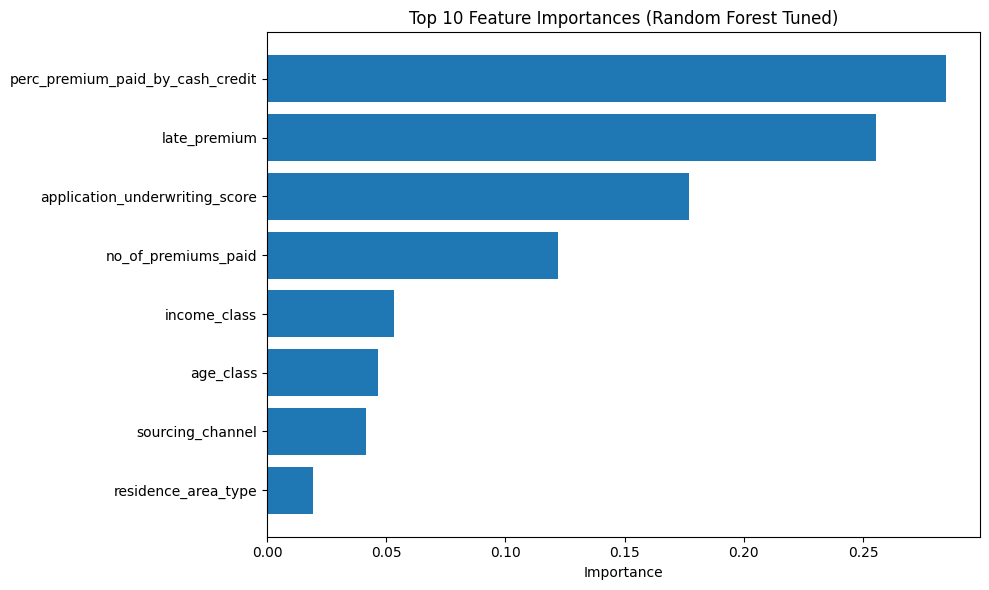

In [15]:

if __name__ == "__main__":
    results_df, models_dict = main('/content/premium_dataset.csv')

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                            roc_auc_score, f1_score, precision_recall_curve,
                            precision_recall_fscore_support)
import warnings
warnings.filterwarnings("ignore")

# Interaction Features

In [17]:
def create_advanced_features(df):
    """Create interaction and derived features"""
    df = df.copy()

    # Basic features from original pipeline
    df['late_premium'] = (df['Count_3-6_months_late'] +
                          df['Count_6-12_months_late'] +
                          df['Count_more_than_12_months_late'])

    df['age'] = df['age_in_days'] // 365
    df['application_underwriting_score'] = df['application_underwriting_score'] / 100

    # 1. High cash payment + Late payments (risky combo)
    df['high_cash_late_combo'] = (
        (df['perc_premium_paid_by_cash_credit'] > 0.5) &
        (df['late_premium'] > 2)
    ).astype(int)

    # 2. Low income + High late payments (financial stress indicator)
    df['financial_stress'] = (
        (df['Income'] < df['Income'].quantile(0.25)) &
        (df['late_premium'] > 1)
    ).astype(int)

    # 3. Payment reliability score (ratio of on-time to total premiums)
    df['payment_reliability'] = df['no_of_premiums_paid'] / (
        df['no_of_premiums_paid'] + df['late_premium'] + 1e-5
    )

    # 4. Risk score combining underwriting + payment history
    df['composite_risk'] = (
        (1 - df['application_underwriting_score']) * 0.4 +
        (df['late_premium'] / (df['late_premium'].max() + 1)) * 0.6
    )

    # 5. Age-Income interaction (older high earners more stable)
    df['age_income_interaction'] = df['age'] * np.log1p(df['Income'])

    # 6. Recent late payment indicator (more weight to recent behavior)
    df['recent_late_weighted'] = (
        df['Count_3-6_months_late'] * 3 +
        df['Count_6-12_months_late'] * 2 +
        df['Count_more_than_12_months_late'] * 1
    )

    # 7. Income sufficiency (income relative to payment method)
    df['income_payment_ratio'] = df['Income'] / (
        df['perc_premium_paid_by_cash_credit'] * df['Income'].median() + 1
    )

    # 8. Binary flags for extreme cases
    df['zero_late_payments'] = (df['late_premium'] == 0).astype(int)
    df['chronic_late_payer'] = (df['late_premium'] >= 5).astype(int)
    df['new_customer'] = (df['no_of_premiums_paid'] <= 3).astype(int)

    print(f"\nCreated {len(df.columns) - len(pd.read_csv('/content/premium_dataset.csv').columns)} new features")

    return df

In [18]:
def calibrate_probabilities(model, X_train, y_train, X_val, y_val, method='isotonic'):
    """
    Calibrate model probabilities using isotonic or sigmoid calibration
    """
    print(f"\nCalibrating probabilities using {method} regression...")

    # Check calibration before
    y_prob_before = model.predict_proba(X_val)[:, 1]

    # Calibrate
    calibrated_model = CalibratedClassifierCV(
        model,
        method=method,
        cv='prefit'
    )
    calibrated_model.fit(X_train, y_train)

    # Check calibration after
    y_prob_after = calibrated_model.predict_proba(X_val)[:, 1]

    # Plot calibration curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Before calibration
    prob_true_before, prob_pred_before = calibration_curve(
        y_val, y_prob_before, n_bins=10, strategy='uniform'
    )
    ax1.plot(prob_pred_before, prob_true_before, marker='o', label='Before')
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect')
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('True Probability')
    ax1.set_title('Before Calibration')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # After calibration
    prob_true_after, prob_pred_after = calibration_curve(
        y_val, y_prob_after, n_bins=10, strategy='uniform'
    )
    ax2.plot(prob_pred_after, prob_true_after, marker='o', label='After', color='green')
    ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect')
    ax2.set_xlabel('Predicted Probability')
    ax2.set_ylabel('True Probability')
    ax2.set_title('After Calibration')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('calibration_comparison.png', dpi=150, bbox_inches='tight')
    print(" Calibration plot saved as 'calibration_comparison.png'")

    return calibrated_model

# Cost Sensitive Models

In [19]:
def train_cost_sensitive_model(X_train, y_train, cost_fp=10, cost_fn=500):
    """
    Train model with custom cost matrix

    Args:
        cost_fp: Cost of false positive (unnecessary intervention)
        cost_fn: Cost of false negative (missed non-payer)
    """
    print(f"\nTraining cost-sensitive model...")
    print(f"   Cost FP (false alarm): ${cost_fp}")
    print(f"   Cost FN (missed non-payer): ${cost_fn}")

    # Calculate class weights based on costs
    # For imbalanced data: weight = cost * (n_samples / (n_classes * n_class_samples))
    n_samples = len(y_train)
    n_class_0 = np.sum(y_train == 0)
    n_class_1 = np.sum(y_train == 1)

    # Cost-based weights
    weight_0 = cost_fn * (n_samples / (2 * n_class_0))
    weight_1 = cost_fp * (n_samples / (2 * n_class_1))

    # Normalize weights
    total_weight = weight_0 + weight_1
    weight_0 = weight_0 / total_weight * 2
    weight_1 = weight_1 / total_weight * 2

    print(f"   Class 0 weight: {weight_0:.2f}")
    print(f"   Class 1 weight: {weight_1:.2f}")

    try:
        import xgboost as xgb

        # XGBoost with scale_pos_weight
        scale_pos_weight = (cost_fn * n_class_0) / (cost_fp * n_class_1)

        model = xgb.XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            scale_pos_weight=scale_pos_weight,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        model.fit(X_train, y_train)

        return model

    except ImportError:
        # Fallback to Random Forest with class_weight
        class_weight = {0: weight_0, 1: weight_1}

        model = RandomForestClassifier(
            n_estimators=300,
            max_depth=10,
            min_samples_leaf=3,
            class_weight=class_weight,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        return model

# Ensemble

In [20]:
def create_stacking_ensemble(X_train, y_train):
    """
    Create stacking ensemble with multiple base models
    """
    print(f"\nBuilding stacking ensemble...")

    # Base models
    base_models = []

    # Model 1: Random Forest
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=3,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    base_models.append(('rf', rf))

    # Model 2: Logistic Regression
    lr = LogisticRegression(
        C=0.1,
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
    base_models.append(('lr', lr))

    # Model 3: XGBoost
    try:
        import xgboost as xgb
        scale_pos_weight = np.sum(y_train == 1) / np.sum(y_train == 0)
        xgb_model = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        base_models.append(('xgb', xgb_model))
    except ImportError:
        print("XGBoost not available, using RF + LR only")

    # Model 4: LightGBM
    try:
        import lightgbm as lgb
        lgb_model = lgb.LGBMClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        base_models.append(('lgb', lgb_model))
    except ImportError:
        pass

    # Meta-learner: Logistic Regression
    meta_learner = LogisticRegression(
        C=1.0,
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )

    # Create stacking ensemble
    stacking = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_learner,
        cv=5,
        n_jobs=-1,
        passthrough=False  # Don't pass original features to meta-learner
    )

    print(f"   Base models: {len(base_models)}")
    print(f"   Meta-learner: Logistic Regression")

    stacking.fit(X_train, y_train)

    return stacking



# Intervention Tiers

In [21]:
def create_intervention_tiers(probabilities, costs):
    # Convert to non-payer probabilities
    non_payer_probs = 1 - probabilities

    # Define tiers
    tiers = []
    actions = []
    tier_costs = []

    for prob in non_payer_probs:
        if prob > 0.7:
            tier = 'High Risk'
            action = 'Personal call + Special offer'
            cost = costs['high']
        elif prob > 0.4:
            tier = 'Medium Risk'
            action = 'Email + SMS reminder'
            cost = costs['medium']
        elif prob > 0.2:
            tier = 'Low-Medium Risk'
            action = 'SMS reminder'
            cost = costs['low']
        else:
            tier = 'Low Risk'
            action = 'Standard communication'
            cost = costs['none']

        tiers.append(tier)
        actions.append(action)
        tier_costs.append(cost)

    return pd.DataFrame({
        'non_payer_probability': non_payer_probs,
        'risk_tier': tiers,
        'intervention_action': actions,
        'intervention_cost': tier_costs
    })

# ROI

In [22]:
def calculate_roi(y_true, tiers_df, policy_value=500):
    """
    Calculate ROI of intervention strategy
    """
    # Costs
    total_intervention_cost = tiers_df['intervention_cost'].sum()

    # Benefits
    actual_non_payers = np.sum(y_true == 0)

    # Identify which non-payers were caught (received intervention)
    non_payers_flagged = np.sum(
        (y_true == 0) & (tiers_df['risk_tier'] != 'Low Risk')
    )

    # Assume 60% of flagged non-payers are retained
    retention_rate = 0.60
    retained_policies = non_payers_flagged * retention_rate
    benefit = retained_policies * policy_value

    # Missed non-payers (cost)
    missed_non_payers = actual_non_payers - non_payers_flagged
    missed_cost = missed_non_payers * policy_value

    # Net benefit
    net_benefit = benefit - total_intervention_cost - missed_cost

    # ROI
    roi = (benefit - total_intervention_cost) / total_intervention_cost * 100

    results = {
        'total_intervention_cost': total_intervention_cost,
        'non_payers_flagged': non_payers_flagged,
        'retained_policies': retained_policies,
        'benefit': benefit,
        'missed_non_payers': missed_non_payers,
        'missed_cost': missed_cost,
        'net_benefit': net_benefit,
        'roi': roi
    }

    return results

# Business Metrics

In [23]:
def evaluate_with_business_metrics(model, X_test, y_test, model_name,
                                   threshold=0.5, intervention_costs=None):
    """Enhanced evaluation with business metrics"""

    if intervention_costs is None:
        intervention_costs = {
            'high': 50,
            'medium': 10,
            'low': 2,
            'none': 0
        }

    # Get predictions and probabilities
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    # Standard metrics
    test_metrics = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)

    # Create intervention tiers
    tiers_df = create_intervention_tiers(y_prob, intervention_costs)

    # Calculate ROI
    roi_results = calculate_roi(y_test, tiers_df, policy_value=500)

    # Print results
    print(f"\n{'='*75}")
    print(f"{model_name}")
    print(f"{'='*75}")
    print(f"Threshold: {threshold:.3f}")

    print(f"\nClassification Metrics:")
    print(f"   Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"   ROC-AUC:   {roc_auc_score(y_test, y_prob):.4f}")
    print(f"   F1 (Class 0): {test_metrics[2][0]:.4f}")
    print(f"   Precision (Class 0): {test_metrics[0][0]:.4f}")
    print(f"   Recall (Class 0): {test_metrics[1][0]:.4f}")

    print(f"\nBusiness Metrics:")
    print(f"   Intervention Cost: ${roi_results['total_intervention_cost']:,.0f}")
    print(f"   Non-payers Flagged: {roi_results['non_payers_flagged']}")
    print(f"   Retained Policies: {roi_results['retained_policies']:.0f}")
    print(f"   Revenue Retained: ${roi_results['benefit']:,.0f}")
    print(f"   Missed Non-payers: {roi_results['missed_non_payers']}")
    print(f"   Missed Revenue: ${roi_results['missed_cost']:,.0f}")
    print(f"   Net Benefit: ${roi_results['net_benefit']:,.0f}")
    print(f"   ROI: {roi_results['roi']:.1f}%")

    # Tier distribution
    print(f"\nRisk Tier Distribution:")
    tier_counts = tiers_df['risk_tier'].value_counts()
    for tier, count in tier_counts.items():
        pct = count / len(tiers_df) * 100
        print(f"   {tier}: {count} ({pct:.1f}%)")

    results = {
        'Model': model_name,
        'Threshold': threshold,
        'Test_Accuracy': accuracy_score(y_test, y_pred),
        'Test_ROC_AUC': roc_auc_score(y_test, y_prob),
        'Test_F1_Class0': test_metrics[2][0],
        'Test_Precision_Class0': test_metrics[0][0],
        'Test_Recall_Class0': test_metrics[1][0],
        'Intervention_Cost': roi_results['total_intervention_cost'],
        'Net_Benefit': roi_results['net_benefit'],
        'ROI': roi_results['roi']
    }

    return results, tiers_df



In [25]:
def deployment(tiers_df, results_df):
    print("\nRISK TIER ACTIONS:")
    tier_counts = tiers_df['risk_tier'].value_counts()
    for tier in ['High Risk', 'Medium Risk', 'Low-Medium Risk', 'Low Risk']:
        if tier in tier_counts.index:
            count = tier_counts[tier]
            pct = count / len(tiers_df) * 100
            action = tiers_df[tiers_df['risk_tier']==tier]['intervention_action'].iloc[0]
            cost = tiers_df[tiers_df['risk_tier']==tier]['intervention_cost'].iloc[0]
            print(f"\n   {tier}: {count} customers ({pct:.1f}%)")
            print(f"      Action: {action}")
            print(f"      Cost per customer: ${cost}")
            print(f"      Total cost: ${count * cost:,.0f}")

    print("\nEXPECTED MONTHLY IMPACT:")
    best_model = results_df.iloc[0]
    print(f"   • Net Benefit: ${best_model['Net_Benefit']:,.0f}")
    print(f"   • ROI: {best_model['ROI']:.1f}%")
    print(f"   • Annual Benefit: ${best_model['Net_Benefit'] * 12:,.0f}")

# Advanced Models

In [24]:

def main_advanced(filepath='/content/premium_dataset.csv'):
    print("\nLoading data...")
    df = pd.read_csv(filepath)
    df = df.drop('id', axis=1)

    # Handle missing values
    late_cols = ['Count_3-6_months_late', 'Count_6-12_months_late',
                 'Count_more_than_12_months_late']
    for col in late_cols:
        df[col].fillna(0, inplace=True)
    df['application_underwriting_score'].fillna(
        df['application_underwriting_score'].median(), inplace=True
    )

    # feature engineering
    print("\nAdvanced feature engineering...")
    df = create_advanced_features(df)

    # Split data
    print("\nSplitting data...")

    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)
    X_train, X_val, X_test, y_train, y_val, y_test = handle_outliers(
        X_train, X_val, X_test, y_train, y_val, y_test
    )
    X_train, X_val, X_test = create_binned_features(X_train, X_val, X_test)

    # Preprocess
    print("\nPreprocessing...")
    X_train_tree, X_val_tree, X_test_tree = preprocess_for_trees(X_train, X_val, X_test)
    X_train_lr, X_val_lr, X_test_lr, scaler = preprocess_for_logreg(X_train, X_val, X_test)

    # Results storage
    results = []

    # ========== BASELINE FOR COMPARISON ==========
    try:
        import xgboost as xgb
        scale_pos_weight = np.sum(y_train == 1) / np.sum(y_train == 0)
        xgb_baseline = xgb.XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        xgb_baseline.fit(X_train_tree, y_train)

        res, _ = evaluate_with_business_metrics(
            xgb_baseline, X_test_tree, y_test,
            "XGBoost (Baseline)", threshold=0.5
        )
        results.append(res)
    except ImportError:
        print("XGBoost not available")

    # ========== CALIBRATED XGBOOST ==========
    print("\n" + "="*75)
    print("PROBABILITY CALIBRATION")
    print("="*75)

    if 'xgb_baseline' in locals():
        xgb_calibrated = calibrate_probabilities(
            xgb_baseline, X_train_tree, y_train, X_val_tree, y_val,
            method='isotonic'
        )

        # Find optimal threshold
        optimal_thresh = find_optimal_threshold(xgb_calibrated, X_val_tree, y_val)

        res, _ = evaluate_with_business_metrics(
            xgb_calibrated, X_test_tree, y_test,
            "XGBoost (Calibrated)", threshold=optimal_thresh
        )
        results.append(res)

    # ========== COST-SENSITIVE MODEL ==========
    print("\n" + "="*75)
    print("COST-SENSITIVE LEARNING")
    print("="*75)

    cost_sensitive_model = train_cost_sensitive_model(
        X_train_tree, y_train,
        cost_fp=10,  # Cost of false alarm
        cost_fn=500  # Cost of missed non-payer
    )

    optimal_thresh = find_optimal_threshold(cost_sensitive_model, X_val_tree, y_val)
    res, _ = evaluate_with_business_metrics(
        cost_sensitive_model, X_test_tree, y_test,
        "Cost-Sensitive Model", threshold=optimal_thresh
    )
    results.append(res)

    # ========== STACKING ENSEMBLE ==========
    print("\n" + "="*75)
    print("STACKING ENSEMBLE")
    print("="*75)

    stacking_model = create_stacking_ensemble(X_train_tree, y_train)

    optimal_thresh = find_optimal_threshold(stacking_model, X_val_tree, y_val)
    res, tiers_final = evaluate_with_business_metrics(
        stacking_model, X_test_tree, y_test,
        "Stacking Ensemble", threshold=optimal_thresh
    )
    results.append(res)

    # ========== COMPARISON ==========
    print("\n" + "="*75)
    print("FINAL COMPARISON")
    print("="*75)

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Net_Benefit', ascending=False)

    display_cols = ['Model', 'Test_F1_Class0', 'Test_Recall_Class0',
                   'Intervention_Cost', 'Net_Benefit', 'ROI']
    print("\n" + results_df[display_cols].to_string(index=False))

    # best Model
    best_model = results_df.iloc[0]
    print(f"\nBEST MODEL: {best_model['Model']}")
    print(f"   Net Benefit: ${best_model['Net_Benefit']:,.0f}")
    print(f"   ROI: {best_model['ROI']:.1f}%")
    print(f"   F1 (Class 0): {best_model['Test_F1_Class0']:.4f}")

    # Save
    results_df.to_csv('advanced_model_results.csv', index=False)
    print("\nResults saved to 'advanced_model_results.csv'")

    # Save best model
    import pickle
    with open('best_model_advanced.pkl', 'wb') as f:
        pickle.dump(stacking_model, f)
    print("Best model saved as 'best_model_advanced.pkl'")

    # Create deployment guide
    deploymen(tiers_final, results_df)

    return results_df, stacking_model




Loading data...

Advanced feature engineering...

Created 11 new features

Splitting data...
Training samples: 47911 -> 40733
Income bounds: [70070, 450040]

Preprocessing...

XGBoost (Baseline)
Threshold: 0.500

Classification Metrics:
   Accuracy:  0.9378
   ROC-AUC:   0.8386
   F1 (Class 0): 0.0312
   Precision (Class 0): 0.6400
   Recall (Class 0): 0.0160

Business Metrics:
   Intervention Cost: $1,098
   Non-payers Flagged: 58
   Retained Policies: 35
   Revenue Retained: $17,400
   Missed Non-payers: 942
   Missed Revenue: $471,000
   Net Benefit: $-454,698
   ROI: 1484.7%

Risk Tier Distribution:
   Low Risk: 15858 (99.3%)
   Low-Medium Risk: 79 (0.5%)
   Medium Risk: 19 (0.1%)
   High Risk: 15 (0.1%)

PROBABILITY CALIBRATION

Calibrating probabilities using isotonic regression...
 Calibration plot saved as 'calibration_comparison.png'

XGBoost (Calibrated)
Threshold: 0.783

Classification Metrics:
   Accuracy:  0.9215
   ROC-AUC:   0.8383
   F1 (Class 0): 0.3462
   Precision (

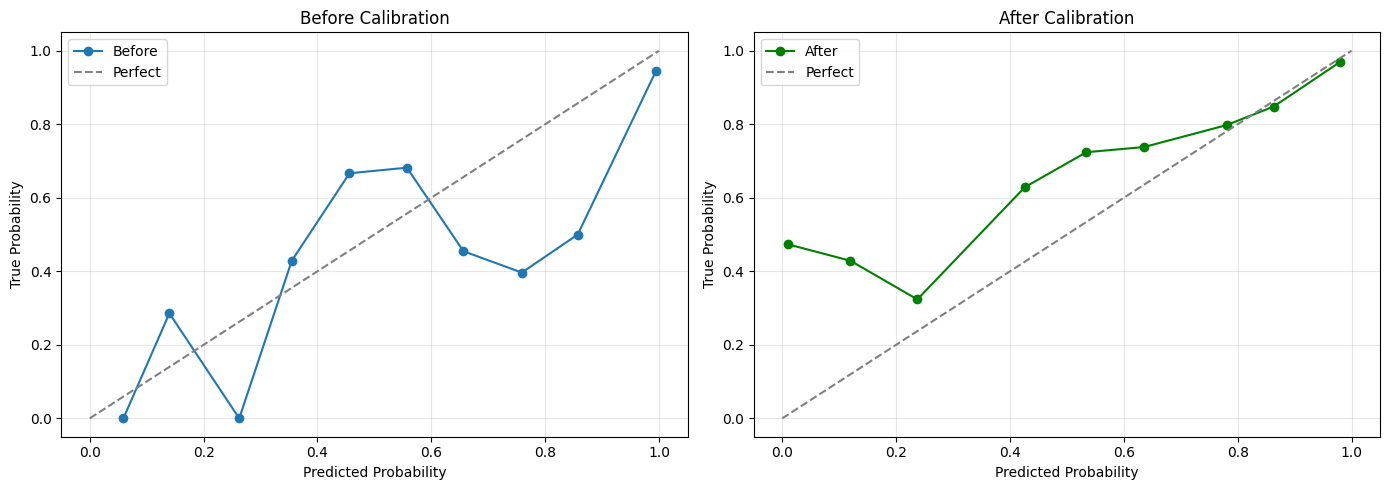

In [26]:

# Run the advanced pipeline
if __name__ == "__main__":
    results_df, best_model = main_advanced('/content/premium_dataset.csv')